## Compute pi values for protein coding genes for isoforms that are NMD vs. not

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [44]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [ ]:
# master table
mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [46]:
def get_melted_pi_counts_table(ver='poder', min_t_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='t_tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    
    # add gene expression
    ver = 'poder'
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tpm_tsv'],od))[0]
    gene_df = pd.read_csv(f, sep='\t')
    gene_df.head()
    gene_df.sort_values(by='geneid.v').head()
    gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
    id_vars = ['gid']
    sample_columns = list(set(gene_df.columns)-set(id_vars))
    gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='g_tpm')
    gene_df.head()
    
    # filter based on min. cpm
    df = df.merge(gene_df, how='left',
                  on=['gid', 'sample'])
    
    
    if min_t_cpm:
        df = df.loc[df.t_tpm >= min_t_cpm]
        
    return df

In [47]:
df = get_melted_pi_counts_table()

In [49]:
# read in protein table
# TODO replace with the new on PODER
# master table
f = expand(proc_cfg(config['lr']['protein']['summary'],od))[0]
p_df = pd.read_csv(f, sep='\t')

In [50]:
p_df = p_df[['tid', 'protein_has_start_codon', 'protein_has_stop_codon', 'protein_is_nmd']]

In [51]:
df.head()

,tid,gid,sample,pi,t_tpm,population,g_tpm
0,ENST00000010132.6,ENSG00000010219.14,CEU1,0.362282,10.64560,CEU,29.384669
1,ENST00000013894.3,ENSG00000011198.10,CEU1,0.000000,0.00000,CEU,4.804048
2,ENST00000075120.12,ENSG00000059804.18,CEU1,0.446028,4.43585,CEU,9.945228
3,ENST00000155093.8,ENSG00000067646.12,CEU1,0.000000,0.00000,CEU,0.000000
4,ENST00000156084.8,ENSG00000068308.15,CEU1,0.000000,0.00000,CEU,4.466921


In [52]:
# inner merge, make sure they are the same len before and after (once we have prot. info from full poder)
# TODO -- what do we do with transcripts that don't have an ORF? what category do those go into?
# need to change to left merge when I have full infromation
l1 = len(df.index)
df = df.merge(p_df, 
              how='inner',
              on='tid')
l2 = len(df.index)
# assert l1 == l2

In [53]:
# 
df['orf_cat'] = 'Incomplete'
df.loc[(df.protein_has_start_codon==True)&\
       (df.protein_has_stop_codon==True), 'orf_cat'] = 'Coding'
df.loc[df['protein_is_nmd']==True, 'orf_cat'] = 'NMD'

# df.loc[(df.protein_has_start_codon.isnull())|\
#        (df.protein_has_stop_codon.isnull()), 'orf_cat'] = 'Incomplete'
# df.loc[(df.protein_has_start_codon==False)|\
#        (df.protein_has_stop_codon==False), 'orf_cat'] = 'Incomplete'

In [54]:
df[['protein_has_start_codon','protein_has_stop_codon','protein_is_nmd','orf_cat']].drop_duplicates()

,protein_has_start_codon,protein_has_stop_codon,protein_is_nmd,orf_cat
0,True,True,False,Coding
387,True,True,True,NMD


In [55]:
df.head()

,tid,gid,sample,pi,t_tpm,population,g_tpm,protein_has_start_codon,protein_has_stop_codon,protein_is_nmd,orf_cat
0,transcript_100,ENSG00000308185.1,CEU1,0.0,0.0,CEU,3.011820,True,True,False,Coding
1,transcript_100,ENSG00000308185.1,ITU2,0.0,0.0,ITU,1.880657,True,True,False,Coding
2,transcript_100,ENSG00000308185.1,HAC1,0.0,0.0,HAC,1.591464,True,True,False,Coding
3,transcript_100,ENSG00000308185.1,HAC2,0.0,0.0,HAC,1.677377,True,True,False,Coding
4,transcript_100,ENSG00000308185.1,MPC4,0.0,0.0,MPC,1.652327,True,True,False,Coding


In [56]:
# get pi per orf categroy
df = df[['gid', 'sample', 'population', 'pi', 'orf_cat']].groupby(['gid', 'orf_cat', 'sample', 'population']).sum().reset_index()

In [57]:
# get gene expression values
g_df = get_melted_pi_counts_table()

In [60]:
df = df.merge(g_df[['gid', 'sample', 'g_tpm']].drop_duplicates(),
              how='left',
              on=['sample', 'gid'])

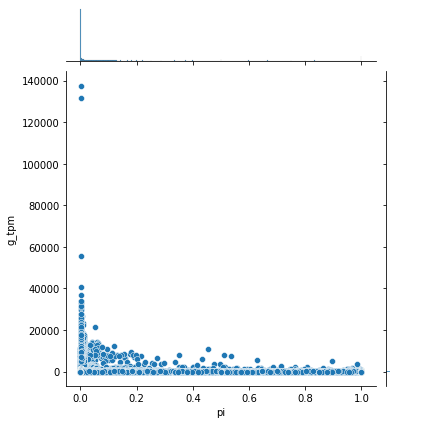

In [62]:
# choose NMD values only
df = df.loc[df.orf_cat == 'NMD']
sns.jointplot(df, x='pi', y='g_tpm')